<p style="font-size:32px;text-align:center"> <b>Toxic Comment Classification</b> </p>

<h1>1. Problem Description</h1>

<p style='font-size:18px'><b> Source :</b> https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/ </p>
<p style='font-size:18px'><b> Data :</b> Wikipedia's CC-SA-3.0</p> 
 
<p style='font-size:18px'><b> Problem Statemtent -</b><br>
Classify the given comments based on the amount of toxicity in it. </p>

<h2>Objectives and Constraints</h2>

* No Strict latency requirement.
* Interpretability is important.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>Data</h2>

<h3>Data Overview</h3>

- Source: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- Provided with a large number of Wikipedia comments which have been labled by human raters for toxic behaviour .<br>
The types of toxicity are : toxic , severe_toxic , obscene , threat , insult , identity_hate<br>

<h2>Mapping the real-world problem to an ML problem</h2>

<h3>Type of Machine Learning Problem </h3>

<p> It is a <b>Multi-Label Classification Problem</b>  <br>
Multi-label Classificatio: Multilabel classification assigns to each sample a set of target labels.
</p>

<h3>Performance metric </h3>

 <b>' Micro F1 Score ' : </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives.<br>
* This is a better metric when we have class imbalance.
<br>

<b>' Macro F1 Score ' : </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>

<b>' Accuracy ' : </b>


<h1> 3. Exploratory Data Analysis </h1>

<h2> Importing Important Modules</h2>

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from wordcloud import WordCloud ,STOPWORDS

import warnings
warnings.filterwarnings("ignore")

<h2> Reading Data</h2>

<h3> Basic Info</h3>

In [3]:
train=pd.read_csv("Data/train.csv")
train.head(2)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


<h3> Data Cleaning</h3>

#### Introducing a new class lable "Clean" for comments without any tags

In [5]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0).astype(int)
#count number of clean entries
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [ ]:
train.to_csv("train.csv",index=False)

In [7]:
train.head(2)

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   

   severe_toxic  obscene  threat  insult  identity_hate  clean  
0             0        0       0       0              0      1  
1             0        0       0       0              0      1

<h3> Checking for NULL values</h3>

In [8]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
clean            False
dtype: bool

Looks like there are no NULL values

<h3> Imbalanced Data</h3>

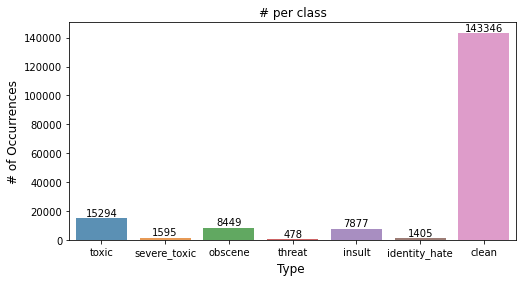

In [9]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

- The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems<br>
- As there is imbalance so the main performance metric will be " Micro F1 Score "
- There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!? <br>
- This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.

<h3> Multi Tagging</h3>

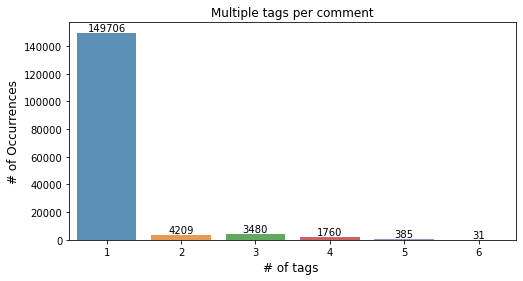

In [10]:
x=train.iloc[:,2:].sum(axis=1).value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

<h4>Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot.</h4>

<AxesSubplot:>

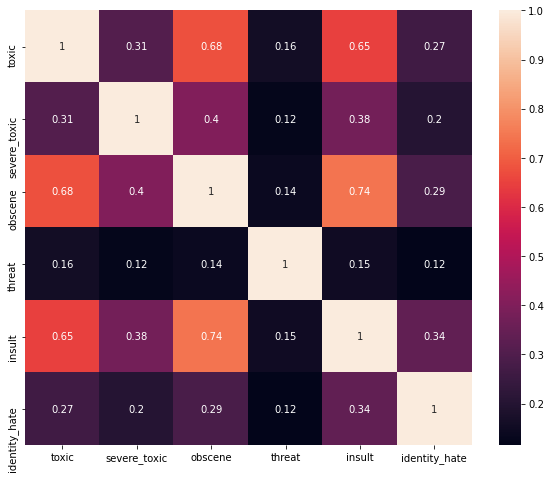

In [11]:
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True )

<h3>Wordclouds - Frequent words:</h3>

<h4>Now, let's take a look at words that are associated with these classes.</h4>

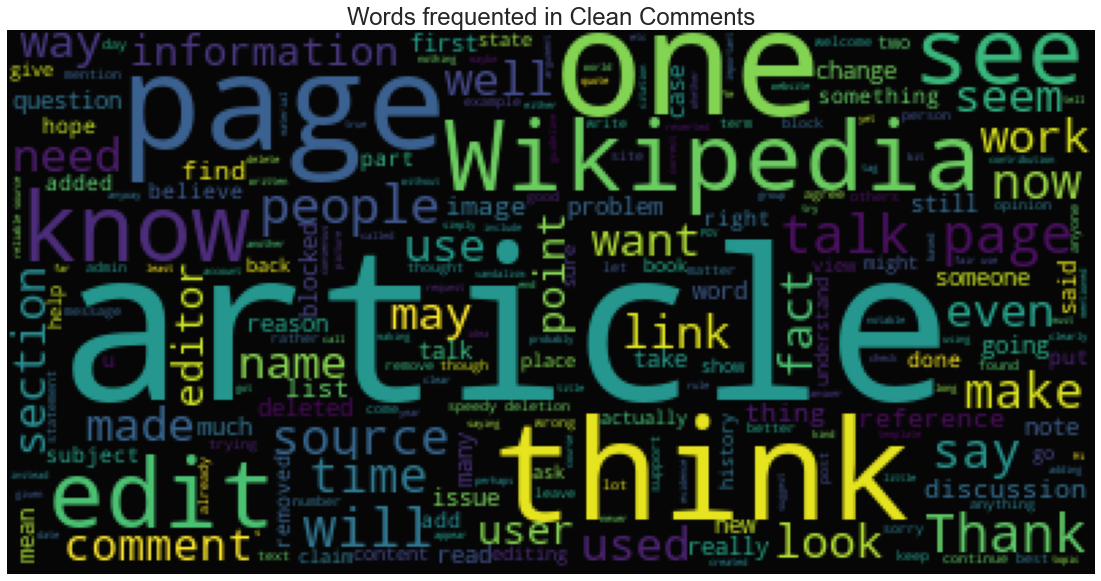

In [42]:
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=24)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

[]

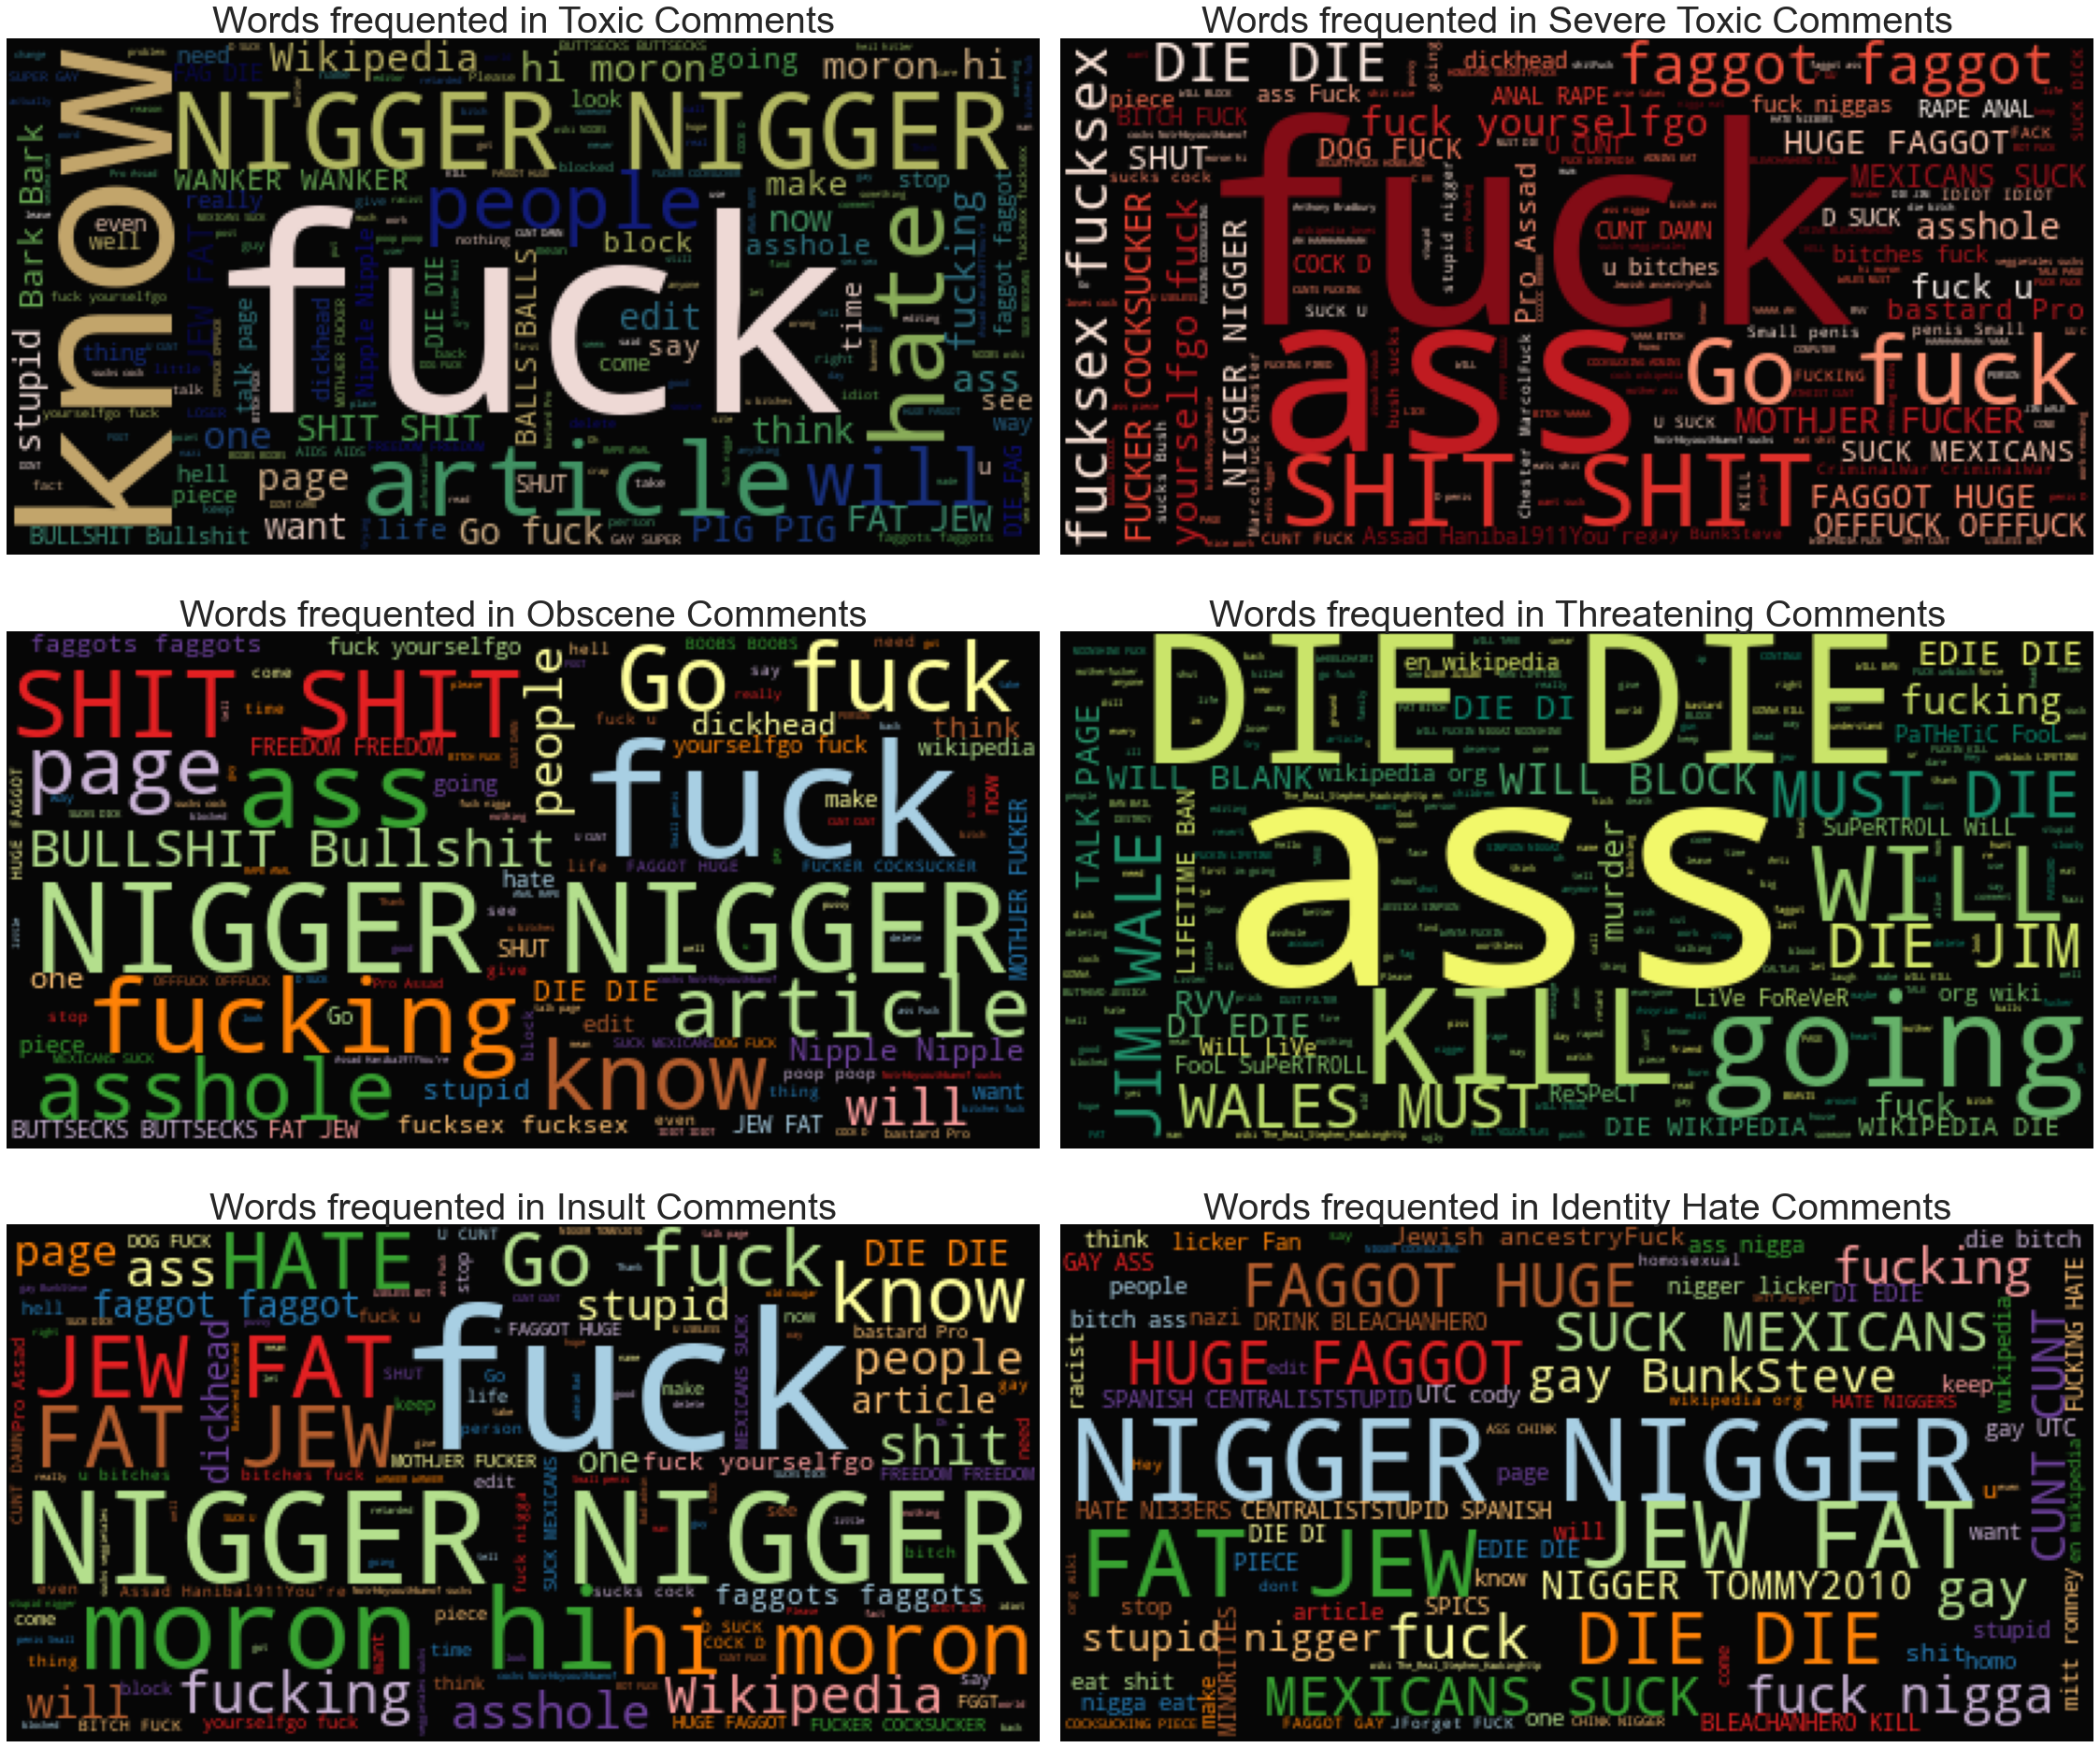

In [149]:
#Toxic comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=3000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(40,40))
plt.subplot(321)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=50)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#--------------------------------------------------------------------------

#Severe Toxic comments
plt.subplot(322)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=3000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=50)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#--------------------------------------------------------------------------

#Obscene comments
plt.subplot(323)
subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=3000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=50)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#--------------------------------------------------------------------------

#Threat comments
plt.subplot(324)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=3000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=50)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=244), alpha=0.98)

#--------------------------------------------------------------------------

#Insult comments
plt.subplot(325)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=3000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=50)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#--------------------------------------------------------------------------

#Identity Hate comments
plt.subplot(326)
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=3000,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Identity Hate Comments", fontsize=40)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.subplots_adjust(wspace=0.02, hspace=-0.3)
plt.plot()

<h3> Evaluating Length of Comments </h3>

Mean :  394.0732213246768 
Standard Deviation :  590.7202819048923 
Maximum Length :  5000


<AxesSubplot:>

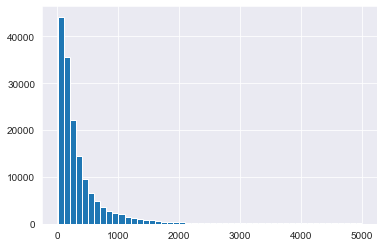

In [60]:
lens = train.comment_text.str.len()
print("Mean : ",lens.mean(),"\nStandard Deviation : ", lens.std(),"\nMaximum Length : ", lens.max())
lens.hist(bins=50)

#### The length of the comments varies a lot . So we have to discard some as outliers .

82.57 % of data have length of Comments in range 20-600


<AxesSubplot:>

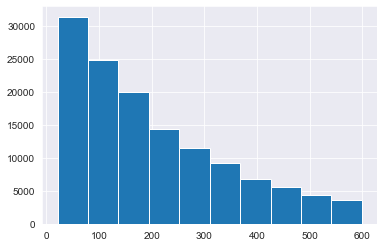

In [50]:
df=train[train['comment_text'].apply(lambda x:len(x)>20 and len(x)<600)]
x=round((df.shape[0]/train.shape[0])*100,2)
print(x,"% of data have length of Comments in range 20-600")
lens1 = df.comment_text.str.len()
lens1.hist()

In [51]:
#Creating a new Dataset named "New_Train(Cmnt_len 20-600).csv" .
df.to_csv("New_Train(Cmnt_len 20-600).csv",index=False)
labels = df.columns[2:9]

<h3> Evaluating Length of Comments per Label</h3>

In [11]:
df['length'] = df.comment_text.apply(lambda x: len(x))
for i in labels:
    print("Average",i,"comment length: %d" % int(np.median(df[df[i]==1].length)))   

Average toxic comment length: 123
Average severe_toxic comment length: 94
Average obscene comment length: 110
Average threat comment length: 121
Average insult comment length: 112
Average identity_hate comment length: 114
Average clean comment length: 216


<h3> Evaluating Capitalization in Comments per Label</h3>

In [12]:
def pct_caps(s):
    return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))
for i in labels:
    print("Percent of capitalized characters in",i,"comments: %d" % int(100 * np.mean(df[df[i]==1].caps)))

Percent of capitalized characters in toxic comments: 15
Percent of capitalized characters in severe_toxic comments: 27
Percent of capitalized characters in obscene comments: 16
Percent of capitalized characters in threat comments: 19
Percent of capitalized characters in insult comments: 15
Percent of capitalized characters in identity_hate comments: 18
Percent of capitalized characters in clean comments: 5


<h3> Evaluating Length of Words of Comments per Label</h3>

In [13]:
def word_length(s):
    s = s.split(' ')
    return np.mean([len(w) for w in s if w.isalpha()])
df['word_length'] = df.comment_text.apply(lambda x: word_length(x))
for i in labels:
    print("Average word length in",i,"comments: %.1f" % np.mean(df[df[i]==1].word_length))

Average word length in toxic comments: 4.1
Average word length in severe_toxic comments: 4.1
Average word length in obscene comments: 4.1
Average word length in threat comments: 3.9
Average word length in insult comments: 4.1
Average word length in identity_hate comments: 4.1
Average word length in clean comments: 4.4


<h3> Evaluating Number of Exclamation Marks in Comments per Label</h3>

In [14]:
df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))
for i in labels:
    print("Exclamations in",i,"comments: %.1f" % np.mean(df[df[i]==1].exclamation))

Exclamations in toxic comments: 3.6
Exclamations in severe_toxic comments: 16.3
Exclamations in obscene comments: 3.3
Exclamations in threat comments: 16.8
Exclamations in insult comments: 3.7
Exclamations in identity_hate comments: 2.3
Exclamations in clean comments: 0.3


<h3> Evaluating Number of Question Marks in Comments per Label</h3>

In [15]:
df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
for i in labels:
    print("Question marks in",i,"comments: %.1f" % np.mean(df[df[i]==1].question))

Question marks in toxic comments: 0.6
Question marks in severe_toxic comments: 0.4
Question marks in obscene comments: 0.5
Question marks in threat comments: 0.3
Question marks in insult comments: 0.5
Question marks in identity_hate comments: 0.4
Question marks in clean comments: 0.4
